In [2]:
import pandas as pd
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, re
from matplotlib.patches import ConnectionPatch
%matplotlib widget

We start reading in the data and do some basic preprocessing. It's a huge dataset, but actually it is the sample used by the Italian Publishers Association (AIE) for the analysis of the university market. The dataset is available [here](https://github.com/claudiotubertini/almalibri)

In [3]:
polimi_2021 = pd.read_csv('adozioni_almalibri_polimi_2021.csv', sep=";", encoding='utf-8')
polito_2021 = pd.read_csv('adozioni_almalibri_polito_2021.zip', sep=";", encoding='utf-8')
unibo_2021 = pd.read_csv('adozioni_almalibri_unibo_2021.zip', sep=";", encoding='utf-8')
unibocconi_2021 = pd.read_csv('adozioni_almalibri_unibocconi_2021.csv', sep=";", encoding='utf-8')
unica_2021 = pd.read_csv('adozioni_almalibri_unica_2021.csv', sep=";", encoding='utf-8')
unicatt_2021 = pd.read_csv('adozioni_almalibri_unicatt_2021.csv', sep=";", encoding='utf-8')
unich_2021 = pd.read_csv('adozioni_almalibri_unich_2021.csv', sep=";", encoding='utf-8')
unife_2021 = pd.read_csv('adozioni_almalibri_unife_2021.csv', sep=";", encoding='utf-8')
unifi_2021 = pd.read_csv('adozioni_almalibri_unifi_2021.csv', sep=";", encoding='utf-8')
unige_2021 = pd.read_csv('adozioni_almalibri_unige_2021.csv', sep=";", encoding='utf-8')
unimi_2021 = pd.read_csv('adozioni_almalibri_unimi_2021.csv', sep=";", encoding='utf-8')
unimib_2021 = pd.read_csv('adozioni_almalibri_unimib_2021.csv', sep=";", encoding='utf-8')
unipa_2021 = pd.read_csv('adozioni_almalibri_unipa_2021.csv', sep=";", encoding='utf-8')
unipd_2021 = pd.read_csv('adozioni_almalibri_unipd_2021.csv', sep=";", encoding='utf-8')
unipi_2021 = pd.read_csv('adozioni_almalibri_unipi_2021.csv', sep=";", encoding='utf-8')
unipr_2021 = pd.read_csv('adozioni_almalibri_unipr_2021.csv', sep=";", encoding='utf-8')
uniroma1_2021 = pd.read_csv('adozioni_almalibri_uniroma1_2021.csv', sep=";", encoding='utf-8')
uniroma3_2021 = pd.read_csv('adozioni_almalibri_uniroma3_2021.csv', sep=";", encoding='utf-8')
unisa_2021 = pd.read_csv('adozioni_almalibri_unisa_2021.csv', sep=";", encoding='utf-8')
unisi_2021 = pd.read_csv('adozioni_almalibri_unisi_2021.csv', sep=";", encoding='utf-8')
unito_2021 = pd.read_csv('adozioni_almalibri_unito_2021.csv', sep=";", encoding='utf-8')
uniurb_2021 = pd.read_csv('adozioni_almalibri_uniurb_2021.csv', sep=";", encoding='utf-8')
unive_2021 = pd.read_csv('adozioni_almalibri_unive_2021.csv', sep=";", encoding='utf-8')
adozioni_2021 = pd.concat([polimi_2021, polito_2021, unibo_2021, unibocconi_2021, unica_2021, unicatt_2021, unich_2021, 
                           unife_2021, unifi_2021, unige_2021, unimi_2021, unimib_2021, unipa_2021, unipd_2021, unipi_2021,
                           unipr_2021, uniroma1_2021, uniroma3_2021, unisa_2021, unisi_2021, unito_2021, uniurb_2021, unive_2021],
                          ignore_index=True)

Every type of degree, in chemistry, in philosophy, etc. has a code. Here is the preprocessing of a few fields to use both almalibri files and the MIUR (the Italian Ministry of Education) ones.

In [4]:
repl = lambda m: m.group(1) + '-' + m.group(2).zfill(2)
adozioni_2021['laurea_classe_cod'] = adozioni_2021['laurea_classe_cod'].fillna(' ')
adozioni_2021['laurea_classe_cod'] = adozioni_2021['laurea_classe_cod'].apply(lambda x: x.split(';')[0])
adozioni_2021['laurea_classe_cod'] = adozioni_2021['laurea_classe_cod'].apply(lambda row: re.sub(r'([LM]+)-(\d{1}$)', repl, row))
cl = pd.read_csv('classi_di_laurea.csv', encoding='utf-8', dtype_backend="pyarrow")
cl['Nome Gruppo Disciplinare'] = cl['Nome Gruppo Disciplinare'].str.strip()
cl['Macro Area Disciplinare'] = cl['Macro Area Disciplinare'].str.strip()
cl = cl[['Numero Classe','Denominazione Classe','Nome Gruppo Disciplinare','Macro Area Disciplinare']]

The levels of degrees are bachelor's degrees, master's degrees, and single cycle master's degrees (law, medicine, dentistry and a few others). We will look into the number of students enrolled in each type of degree course for the different levels, and the number of books that should be bought by students, and eventually the total theoretical sales. That is the size of the market if all students bought all the books they should buy in spite of pirate copies, second hand copies sales, etc. Before Almalibri data were available, the only data were the subjective ones provided by the publishers, based only on the actual sales of the titles written for the university market. Using Almalibri database allows to evaluate the market size on the titles used in the courses, not on those thought to be used in university courses.

In [5]:
triennali_2021 = adozioni_2021[(adozioni_2021['laurea_tipo']=='L') & (adozioni_2021['testo_obb']=='obb')] # bachelor's
magistrali_2021 = adozioni_2021[(adozioni_2021['laurea_tipo']=='LM') & (adozioni_2021['testo_obb']=='obb')] # master's
ciclo_unico_2021 = adozioni_2021[(adozioni_2021['laurea_tipo']=='LMCU') & (adozioni_2021['testo_obb']=='obb')] # single cycle

In [6]:
# merge with type of degrees, that is the area of study
triennali_2021 = triennali_2021.merge(cl, left_on='laurea_classe_cod', right_on='Numero Classe', how='left')
magistrali_2021 = magistrali_2021.merge(cl, left_on='laurea_classe_cod', right_on='Numero Classe', how='left')
ciclo_unico_2021 = ciclo_unico_2021.merge(cl, left_on='laurea_classe_cod', right_on='Numero Classe', how='left')
triennali_2021.rename(columns={'Nome Gruppo Disciplinare': 'area'}, inplace=True)
magistrali_2021.rename(columns={'Nome Gruppo Disciplinare': 'area'}, inplace=True)
ciclo_unico_2021.rename(columns={'Nome Gruppo Disciplinare': 'area'}, inplace=True)
triennali_2021.dropna(subset=['area'], inplace=True)
magistrali_2021.dropna(subset=['area'], inplace=True)
ciclo_unico_2021.dropna(subset=['area'], inplace=True)

In [7]:
# a bit of cleaning
triennali_2021 = triennali_2021[['uni_cod','a_a','laurea_nome','materia_nome','isbn','autori','curatori','titolo','editore','prezzo','laurea_matricole','area']]
magistrali_2021 = magistrali_2021[['uni_cod','a_a','laurea_nome','materia_nome','isbn','autori','curatori','titolo','editore','prezzo','laurea_matricole','area']]
ciclo_unico_2021 = ciclo_unico_2021[['uni_cod','a_a','laurea_nome','materia_nome','isbn','autori','curatori','titolo','editore','prezzo','laurea_matricole','area']]
triennali_2021['autore'] = triennali_2021['autori'] + ' ' + triennali_2021['curatori']
magistrali_2021['autore'] = magistrali_2021['autori'] + ' ' + magistrali_2021['curatori']
ciclo_unico_2021['autore'] = ciclo_unico_2021['autori'] + ' ' + ciclo_unico_2021['curatori']
triennali_2021.drop(columns=['autori', 'curatori'], inplace=True)
magistrali_2021.drop(columns=['autori', 'curatori'], inplace=True)
ciclo_unico_2021.drop(columns=['autori', 'curatori'], inplace=True)

In [8]:
triennali_2021['laurea_nome'] = triennali_2021['laurea_nome'].str.replace('^INFERMIERISTICA \([\w\s]+\)[\s\W\w-]+', 'INFERMIERISTICA', case=True, regex=True)

In [9]:
# to count the books we actually count the isbn; the Education Ministry reports only the number of students for each degree course, so we drop duplicates with 
# subset=['uni_cod','a_a','laurea_nome','isbn'] and then we sum the number of students for each isbn
isbn_triennali_2021 = triennali_2021.drop_duplicates(subset=['uni_cod','a_a','laurea_nome','isbn']).sort_values(by=['laurea_matricole'], ascending=False)
isbn_magistrali_2021 = magistrali_2021.drop_duplicates(subset=['uni_cod','a_a','laurea_nome','isbn']).sort_values(by=['laurea_matricole'], ascending=False)
isbn_ciclo_unico_2021 = ciclo_unico_2021.drop_duplicates(subset=['uni_cod','a_a','laurea_nome','isbn']).sort_values(by=['laurea_matricole'], ascending=False)

# number of students for each isbn
studenti_triennali_2021 = isbn_triennali_2021.groupby(['isbn']).aggregate({'uni_cod':'first','a_a':'first','autore':'first','titolo':'first','editore':'first','prezzo':'first','laurea_matricole': 'sum', 'laurea_nome': 'first', 'area':'first'}).reset_index()
studenti_magistrali_2021 = isbn_magistrali_2021.groupby(['isbn']).aggregate({'uni_cod':'first','a_a':'first','autore':'first','titolo':'first','editore':'first','prezzo':'first','laurea_matricole': 'sum', 'laurea_nome': 'first', 'area':'first'}).reset_index()
studenti_ciclo_unico_2021 = isbn_ciclo_unico_2021.groupby(['isbn']).aggregate({'uni_cod':'first','a_a':'first','autore':'first','titolo':'first','editore':'first','prezzo':'first','laurea_matricole': 'sum', 'laurea_nome': 'first', 'area':'first'}).reset_index()

In [49]:
studenti_triennali_2021.head()

,isbn,uni_cod,a_a,autore,titolo,editore,prezzo,laurea_matricole,laurea_nome,area,fatturato
0,2560752031861,unipr,2021,None,"Dewey. Vita, pensiero, opere scelte",Il Sole 24 Ore,12.00,54,STUDI FILOSOFICI,Letterario-Umanistico,648
1,9771826608374,unipd,2021,None,Donatello e il primo Rinascimento,Il Sole 24 Ore,28.00,510,LETTERE,Letterario-Umanistico,14280
3,9780006514091,unibo,2021,None,The Glass Palace,The Borough Press,11.89,415,LINGUE E LETTERATURE STRANIERE,Linguistico,4934
4,9780007207718,unipd,2021,None,Tree Guide.The most complete field guide to th...,Collins,23.82,23,RIASSETTO DEL TERRITORIO E TUTELA DEL PAESAGGIO,Architettura e Ingegneria civile,548
5,9780007218295,uniroma1,2021,None,Saturday,Anchor Books,16.45,678,LETTERE MODERNE,Letterario-Umanistico,11153


In [10]:
# The size of the market is the number of students, that is repeated for all isbn, the isbn being taken only once 
# for each degree course, times the price of the book.
studenti_triennali_2021['fatturato'] = studenti_triennali_2021['prezzo']*studenti_triennali_2021['laurea_matricole']
studenti_magistrali_2021['fatturato'] = studenti_magistrali_2021['prezzo']*studenti_magistrali_2021['laurea_matricole']
studenti_ciclo_unico_2021['fatturato'] = studenti_ciclo_unico_2021['prezzo']*studenti_ciclo_unico_2021['laurea_matricole']
# we round the turnover to integer
studenti_triennali_2021['fatturato'] = studenti_triennali_2021['fatturato'].round(0).astype(int)
studenti_magistrali_2021['fatturato'] = studenti_magistrali_2021['fatturato'].round(0).astype(int)
studenti_ciclo_unico_2021['fatturato'] = studenti_ciclo_unico_2021['fatturato'].round(0).astype(int)
# not every course has the number of students, so we drop the NaNs
studenti_triennali_2021 = studenti_triennali_2021[studenti_triennali_2021['fatturato']>0]
studenti_magistrali_2021 = studenti_magistrali_2021[studenti_magistrali_2021['fatturato']>0]
studenti_ciclo_unico_2021 = studenti_ciclo_unico_2021[studenti_ciclo_unico_2021['fatturato']>0]

The area of study are: 
Education, Arts and Design, Humanities, Languages, Law, Economics, Social Sciences and Communication, Psychology, Sciences,
Computer Science, Engineering, Architecture, Agriculture and Veterinary, Medicine and Pharmacy, Sport Sciences.


In [11]:
# Bachelor's Degrees
# we group by area of study, and we count the number of books and the turnover
isbn_triennali_2021 = studenti_triennali_2021.groupby(['area']).aggregate({'isbn': 'count','fatturato':'sum'}).reset_index()
area_triennali_2021 = studenti_triennali_2021.drop_duplicates(subset=['uni_cod','a_a','laurea_nome','area'])
# we group by area of study, and we count the number of students and the mean number of students in each degree course
mean_triennali_2021 = area_triennali_2021[['uni_cod','a_a','laurea_nome','area','laurea_matricole']].groupby(['area']).aggregate({'laurea_matricole': ['mean','sum']}).reset_index()
mean_triennali_2021.columns = mean_triennali_2021.columns.map('|'.join).str.strip('|')
ret_triennali_2021 = mean_triennali_2021.merge(isbn_triennali_2021, left_on='area', right_on='area', how='inner')
ret_triennali_2021['laurea_matricole|mean'] = ret_triennali_2021['laurea_matricole|mean'].round(0).astype(int)
#ret_triennali_2021.head()

In [48]:
ret_triennali_2021.to_json('triennali_2021.json', orient='records')

In [12]:
ret_triennali_2021.to_html('triennali_2021.html')

In [13]:
# Master's Degrees
# we group by area of study, and we count the number of books and the turnover
isbn_magistrali_2021 = studenti_magistrali_2021.groupby(['area']).aggregate({'isbn': 'count','fatturato':'sum'}).reset_index() #!isbn e fatturato
area_magistrali_2021 = studenti_magistrali_2021.drop_duplicates(subset=['uni_cod','a_a','laurea_nome','area'])
mean_magistrali_2021 = area_magistrali_2021.groupby(['area']).aggregate({'laurea_matricole': ['mean','sum']}).reset_index()
mean_magistrali_2021.columns = mean_magistrali_2021.columns.map('|'.join).str.strip('|')
ret_magistrali_2021 = mean_magistrali_2021.merge(isbn_magistrali_2021, left_on='area', right_on='area', how='inner')
ret_magistrali_2021['laurea_matricole|mean'] = ret_magistrali_2021['laurea_matricole|mean'].round(0).astype(int)
#ret_magistrali_2021.head()

In [14]:
ret_magistrali_2021.to_html('magistrali_2021.html')

In [15]:
# Single Cycle Master's Degrees 
# we group by area of study, and we count the number of books and the turnover
isbn_ciclo_unico_2021 = studenti_ciclo_unico_2021.groupby(['area']).aggregate({'isbn': 'count','fatturato':'sum'}).reset_index() #!isbn e fatturato
area_ciclo_unico_2021 = studenti_ciclo_unico_2021.drop_duplicates(subset=['uni_cod','a_a','laurea_nome','area'])
mean_ciclo_unico_2021 = area_ciclo_unico_2021.groupby(['area']).aggregate({'laurea_matricole': ['mean','sum']}).reset_index()
mean_ciclo_unico_2021.columns = mean_ciclo_unico_2021.columns.map('|'.join).str.strip('|')
ret_ciclo_unico_2021 = mean_ciclo_unico_2021.merge(isbn_ciclo_unico_2021, left_on='area', right_on='area', how='inner')
ret_ciclo_unico_2021['laurea_matricole|mean'] = ret_ciclo_unico_2021['laurea_matricole|mean'].round(0).astype(int)
#ret_ciclo_unico_2021.head()

In [16]:
ret_ciclo_unico_2021.to_html('ciclo_unico_2021.html')

In [17]:
ret_triennali_2021.set_index('area', inplace=True)
ret_ciclo_unico_2021.set_index('area', inplace=True)
ret_magistrali_2021.set_index('area', inplace=True)

The turnover in the sample is referred to a number of students that is a bit less than 50%. So we can obtain the total turnover by multiplying the turnover in the sample by 2.04.

In [18]:
ft = ret_triennali_2021['fatturato'] *2.04
ft2 = ret_magistrali_2021['fatturato'] *2.04
ft3 = ret_ciclo_unico_2021['fatturato'] *2.04
fatt = pd.concat([ft, ft2, ft3], axis=1)
# Not all area of study are present in all levels, so we fill the NaNs with 0 
fatt.fillna(0, inplace=True)
fatt.columns = ['triennali', 'magistrali', 'ciclo unico']
fatt = fatt.astype(int)

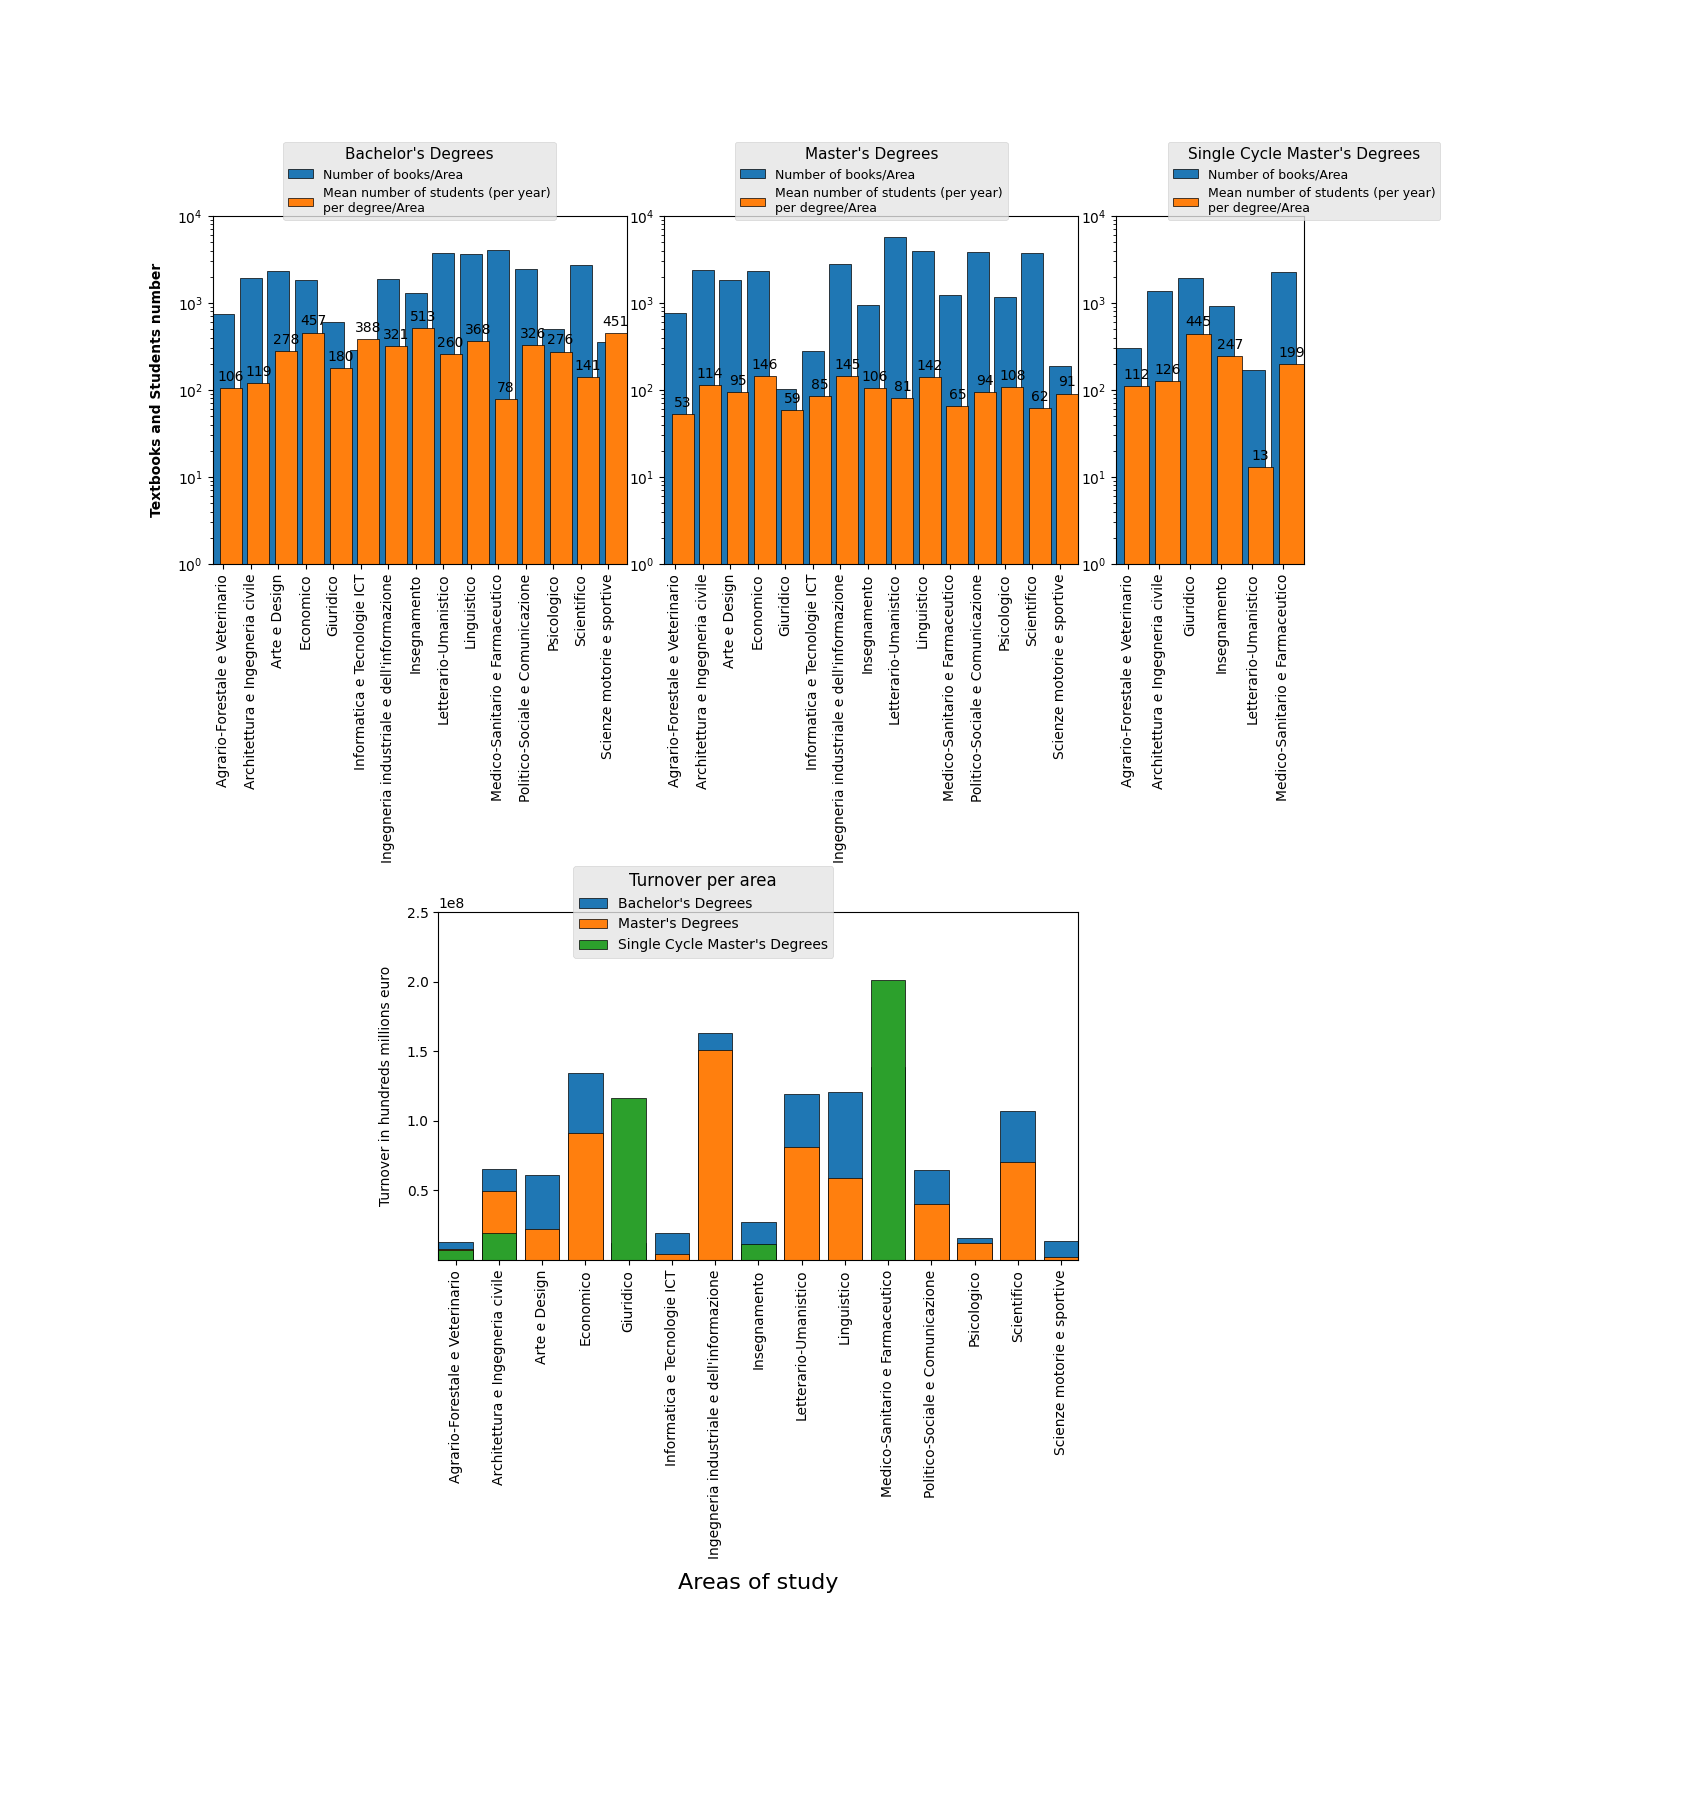

In [19]:
class LineBuilder:
    def __init__(self, line):
        self.line = line
        self.label = []
        #self.xs = list(line.get_xdata())
        #self.ys = list(line.get_ydata())
        self.xs = [-1]
        self.ys = list(line.get_ydata())
        self.ax = line.axes
        self.cid = line.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        if event.inaxes!=self.line.axes: return
        if len(self.label) > 0:
            self.label[-1].remove()
        self.ys[0] = event.ydata
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.line.set_data(self.xs, self.ys)
        self.label.append(self.ax.text(self.xs[1], self.ys[1], f'{self.ys[1]:.0f}', rotation=0, verticalalignment='center', 
                                  color='black', fontsize=10, fontweight='bold'))
        self.line.figure.canvas.draw()
        self.xs.pop(0)
        self.ys.pop(0)
        self.xs[0] = -1
        
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(17,18))
gspec = gridspec.GridSpec(2, 6)

ax1 = plt.subplot(gspec[0, 0:2])
ax2 = plt.subplot(gspec[0, 2:4], sharey=ax1)
ax3 = plt.subplot(gspec[0, 4], sharey=ax1)
ax4 = plt.subplot(gspec[1, 1:4])
#ax5 = plt.subplot(gspec[2, 1:4])
#plt.style.use("seaborn-v0_8-bright")
plt.style.use("ggplot")
#fig.subplots_adjust(left = 0.1, right = 0.9, bottom = 0.3, top = 0.9)
fig.subplots_adjust(hspace=1, wspace=0.2, bottom = 0.3)

# ax2
label = ret_magistrali_2021.index.to_list()
x = np.arange(len(label))
width = 0.8
rect1 = ax2.bar(x,
            ret_magistrali_2021['isbn'].to_list(),
            width = width,
            label = "Number of books/Area",
            edgecolor = "black", log=1
            )
rect2 = ax2.bar(x + width/3,
              ret_magistrali_2021['laurea_matricole|mean'].to_list(),
              width = width, 
              label = "Mean number of students (per year)\nper degree/Area",
              edgecolor = "black")
ax2.bar_label(rect2, padding=3)
ax2.set_xticks(x,label)
ax2.set_ylim(1, 10000)
# ax2.set_xlabel("Aree",
#              fontsize = 10,
#              labelpad = 10)
# ax2.set_ylabel("Titoli adottati e numero studenti",
#              fontsize = 10,
#              labelpad = 10)
ax2.margins(x=0)
ax2.legend(title = "Master's Degrees",
         fontsize = 9,
         title_fontsize = 11,
         bbox_to_anchor=(0.5, 1.1), loc= 'center')
ax2.tick_params(axis = "x", 
              rotation = 90,
              labelsize = 10)
ax2.tick_params(axis = "y",
              labelsize = 10)
line, = ax2.plot([0], [0], color='red', linewidth=2, linestyle='--') 
linebuilder = LineBuilder(line)
# ax3
label = ret_ciclo_unico_2021.index.to_list()
x = np.arange(len(label))
width = 0.8
rect1 = ax3.bar(x,
            ret_ciclo_unico_2021['isbn'].to_list(),
            width = width,
            label = "Number of books/Area",
            edgecolor = "black", log=1
            )
rect2 = ax3.bar(x + width/3,
              ret_ciclo_unico_2021['laurea_matricole|mean'].to_list(),
              width = width, 
              label = "Mean number of students (per year)\nper degree/Area",
              edgecolor = "black")
ax3.bar_label(rect2, padding=3)
ax3.set_xticks(x,label)
ax3.set_ylim(1, 10000)
ax3.margins(x=0)
ax3.legend(title = "Single Cycle Master's Degrees",
         fontsize = 9,
         title_fontsize = 11,
         bbox_to_anchor=(1, 1.1), loc= 'center')
ax3.tick_params(axis = "x", 
              rotation = 90,
              labelsize = 10)
ax3.tick_params(axis = "y",
              labelsize = 10)
line, = ax3.plot([0], [0], color='red', linewidth=2, linestyle='--') 
linebuilder = LineBuilder(line)
# ax1
label = ret_triennali_2021.index.to_list()
x = np.arange(len(label))
width = 0.8
rect1 = ax1.bar(x,
            ret_triennali_2021['isbn'].to_list(),
            width = width,
            label = "Number of books/Area",
            edgecolor = "black", log=1
            )
rect2 = ax1.bar(x + width/3,
              ret_triennali_2021['laurea_matricole|mean'].to_list(),
              width = width, 
              label = "Mean number of students (per year)\nper degree/Area",
              edgecolor = "black")
ax1.bar_label(rect2, padding=3)
ax1.set_xticks(x,label)
ax1.set_ylim(1, 10000)
# ax1.set_xlabel("Aree",
#              fontsize = 10,
#              labelpad = 10)
ax1.set_ylabel("Textbooks and Students number",
             fontsize = 10,
             labelpad = 10,
             fontweight='bold')
ax1.margins(x=0)
ax1.legend(title = "Bachelor's Degrees",
         fontsize = 9,
         title_fontsize = 11,
         bbox_to_anchor=(0.5, 1.1), loc= 'center')
ax1.tick_params(axis = "x", 
              rotation = 90,
              labelsize = 10)
ax1.tick_params(axis = "y",
              labelsize = 10)
line, = ax1.plot([0], [0], color='red', linewidth=2, linestyle='--') 
linebuilder = LineBuilder(line)
#ax4
label = fatt.index
x = np.arange(len(fatt.index))
width = 0.8
rect1 = ax4.bar(x,
            fatt['triennali'].to_list(),
            width = width, 
            label = "Bachelor's Degrees",
            edgecolor = "black")
rect2 = ax4.bar(x,
              fatt['magistrali'].to_list(),
              width = width, 
              label = "Master's Degrees",
              edgecolor = "black")
rect3 = ax4.bar(x,
              fatt['ciclo unico'].to_list(),
              width = width, 
              label = "Single Cycle Master's Degrees",
              edgecolor = "black")
ax4.set_xticks(x,label)
ax4.margins(x=0, y=0)
ax4.set_ylim(1, 250000000)
ax4.set_xlabel("Areas of study",
             fontsize = 16,
             labelpad = 10)
ax4.set_ylabel("Turnover in hundreds millions euro",
             fontsize = 10,
             labelpad = 10)
ax4.legend(title = "Turnover per area",
         fontsize = 10,
         title_fontsize = 12,
         loc = "center left", bbox_to_anchor=(0.2, 1))
ax4.tick_params(axis = "x", 
              rotation = 90,
              labelsize = 10 )
ax4.tick_params(axis = "y",
              labelsize = 10)
line, = ax4.plot([0], [0], color='green', linewidth=2, linestyle='--') 
linebuilder = LineBuilder(line)

plt.show()


In [40]:
plt.close()